In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import reservoirpy as rp
from reservoirpy.nodes import Reservoir, Ridge, Input
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
from sklearn.metrics import accuracy_score

In [2]:
def print_shape(x):
    print(x.shape)

In [3]:
df = pd.read_csv('data.csv')

# remove the date column
date_time = df.pop('date')

Y = df.pop('incidents')
X = df


In [4]:
months = pd.to_datetime(date_time, format='%Y-%m-%d').dt.month

In [5]:
df.head()

,"('temperature', 'mean')","('temperature', 'max')","('temperature', 'min')","('humidite', 'mean')","('humidite', 'max')","('humidite', 'min')","('nuages', 'mean')","('nuages', 'max')","('nuages', 'min')"
0,8.407479,10.476465,5.921381,86.976287,96.8684,72.3197,88.009513,100.0,46.87500
1,10.482559,13.003564,8.543604,89.939588,96.2094,81.1347,91.015629,100.0,35.93750
2,10.108455,12.519678,8.909326,94.035604,97.8528,89.3497,95.084633,100.0,67.18750
3,8.958734,12.460107,5.731348,86.352908,92.5699,68.4599,73.518883,100.0,0.00000
4,7.104425,8.300439,5.926172,90.596867,96.4792,78.9225,66.927081,100.0,5.46875


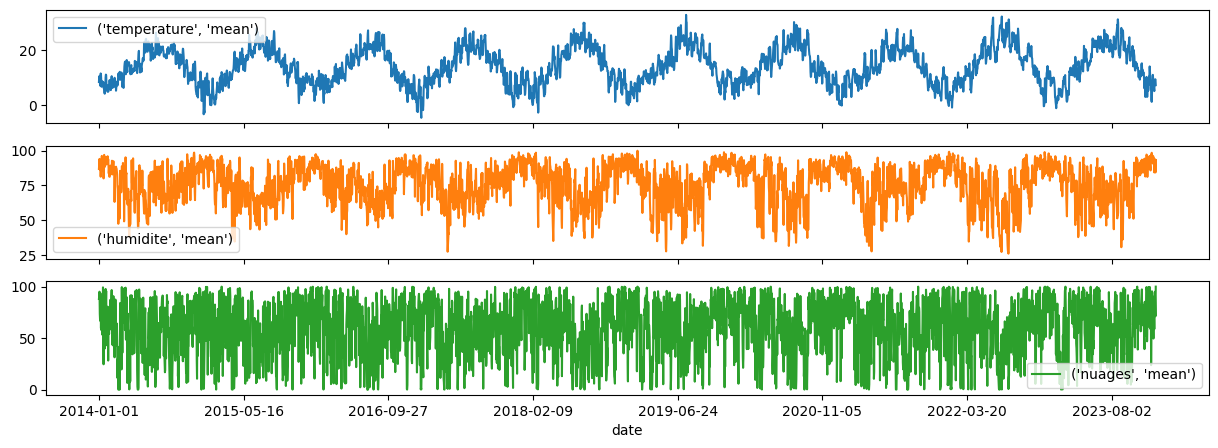

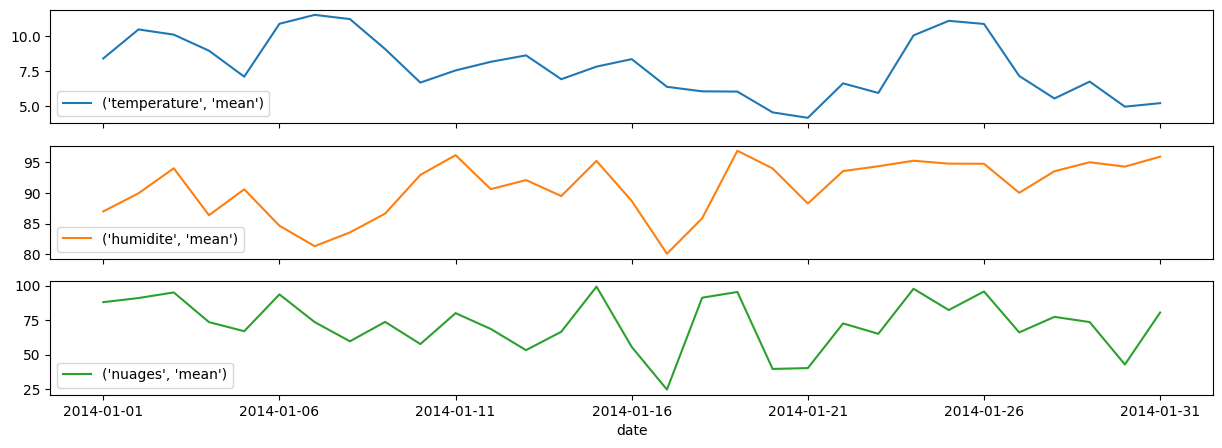

In [6]:

plot_cols = ["('temperature', 'mean')", "('humidite', 'mean')", "('nuages', 'mean')"]
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True, figsize=(15, 5))

plot_features = df[plot_cols][:31]
plot_features.index = date_time[:31]
_ = plot_features.plot(subplots=True, figsize=(15, 5))

In [7]:
# split train and test (test = last 300 days, train = rest)
# X = ('temperature', 'mean')	('temperature', 'max')	('temperature', 'min')	('humidite', 'mean')	('humidite', 'max')	('humidite', 'min')	('nuages', 'mean')	('nuages', 'max')	('nuages', 'min')
# Y = incidents (0 or 1 or 2)
train_df = df[:-300]
test_df = df[-300:]
train_labels = Y[:-300]
test_labels = Y[-300:]

# normalize data
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

train_data = np.array(train_df)
train_labels = np.array(train_labels)
test_data = np.array(test_df)
test_labels = np.array(test_labels)
# transform labels to one hot
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)


(3353, 9)
(3353, 3)
(300, 9)
(300, 3)


In [8]:
def get_periods_indices(months, start_month, end_month, test=False):
    if test is False:
        return [
            index for index in range(len(months))
            if months[index] > start_month and months[index] < end_month and index < (len(months) - 300)
        ]
    else :
        return [
            index for index in range(len(months))
            if months[index] > start_month and months[index] < end_month >= (len(months) - 300)
        ][-300:]

In [9]:
# create a model to predict if today is a risky day, very risky day or not (0, 1, 2) using reservoirpy

# create a reservoir
source = Input()
reservoir = Reservoir(500, sr=0.9, lr=0.1)
readout = Ridge(ridge=1e-2)



train_states = reservoir.run(train_data)

# Get the indices of the summer months
summer_periods_indices_train = [
            index for index in range(len(months))
            if months[index] > 4 and months[index] < 9 and index < (len(months) - 300)
        ]
summer_periods_indices_test = [
            index for index in range(len(months))
            if months[index] > 4 and months[index] < 9 and index >= (len(months) - 300)
        ]

train_states_filtered = train_states[summer_periods_indices_train]
train_labels_filtered = train_labels[summer_periods_indices_train]

readout.fit(train_states_filtered, train_labels_filtered)

Running Reservoir-0: 100%|██████████| 3353/3353 [00:00<00:00, 20436.65it/s]


'Ridge-0': Ridge(ridge=0.01, input_bias=True, in=500, out=3)

In [10]:
summer_periods_indices_test = np.array(summer_periods_indices_test) - (len(months) - 300) 


In [11]:
test_states = reservoir.run(test_data)
Y_pred = readout.run(test_states)
print(test_data.shape)
print(Y_pred.shape)

Running Ridge-0: 100%|██████████| 300/300 [00:00<00:00, 38614.47it/s]

(300, 9)
(300, 3)


In [12]:
Y_pred_filtered = Y_pred[summer_periods_indices_test]
test_filtered_labels = test_labels[summer_periods_indices_test]

In [13]:
Y_pred_filtered.shape

(123, 3)

In [14]:
# model = [source >> reservoir, source] >> readout
# Y_pred_2 = model.fit(train_states_filtered, train_labels_filtered, stateful=False).run(test_data, stateful=False)

In [15]:
print(train_states_filtered.shape)
print_shape(test_data)

(1107, 500)
(300, 9)


In [16]:
Y_pred_class = [np.argmax(y_p) for y_p in Y_pred_filtered]
Y_test_class = [np.argmax(y_t) for y_t in test_filtered_labels]

score = accuracy_score((Y_test_class), (Y_pred_class))

print("Accuracy: ", f"{score * 100:.3f} %")

Accuracy:  70.732 %


In [17]:
print(f"Y pred class:\n0 count : {Y_pred_class.count(0)}\n1 count : {Y_pred_class.count(1)}\n2 count : {Y_pred_class.count(2)}", end="\n\n")
print(f"Y test class:\n0 count : {Y_test_class.count(0)}\n1 count : {Y_test_class.count(1)}\n2 count : {Y_test_class.count(2)}")

Y pred class:
0 count : 102
1 count : 21
2 count : 0

Y test class:
0 count : 103
1 count : 14
2 count : 6


In [18]:
# plt.figure(figsize=(15,5))
# import confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(Y_test_class, Y_pred_class)

#  réel  [93, 14,  3],
#  réel  [ 7,  0,  0],
#  réel  [ 3,  0,  3]
#  prédit  0   1   2

array([[85, 18,  0],
       [12,  2,  0],
       [ 5,  1,  0]])

---

In [19]:
rp.verbosity(0) 

0

In [20]:
print(train_states_filtered.shape, train_labels_filtered.shape, test_states.shape, test_labels.shape)

(1107, 500) (1107, 3) (300, 500) (300, 3)


In [21]:
dataset = (train_states_filtered, train_labels_filtered, test_states, test_labels)

In [22]:
from reservoirpy.observables import nrmse, rsquare
from reservoirpy.nodes import Reservoir, Ridge, Input
from sklearn.metrics import f1_score

# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other 
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, iss, N, sr, lr, ridge, seed):
    
    # This step may vary depending on what you put inside 'dataset'
    (X_train, y_train, X_test, y_test) = dataset
    
    # You can access anything you put in the config 
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances, 
    # to be sure there is no bias in the results 
    # due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(N, 
                              sr=sr, 
                              lr=lr, 
                              inut_scaling=iss, 
                              seed=variable_seed)
        
        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(X_train, y_train) \
                           .run(X_test)
        pred_filtered = predictions[summer_periods_indices_test]
        Y_pred_class = [np.argmax(y_p) for y_p in pred_filtered]
        Y_test_class = [np.argmax(y_t) for y_t in test_filtered_labels]

        # loss = nrmse(Y_test_class, Y_pred_class, norm_value=np.ptp(X_train))
        loss = 1 - f1_score(Y_test_class, Y_pred_class, average='weighted')
        r2 = rsquare(Y_test_class, Y_pred_class)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s),
            'f1_score': f1_score(Y_test_class, Y_pred_class, average='weighted'),}

In [23]:
hyperopt_config = {
    "exp": f"hyperopt-enedis-1",     # the experimentation name
    "hp_max_evals": 200,                # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",              # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                         # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,           # how many random ESN will be tried with each sets of parameters
    "hp_space": {                       # what are the ranges of parameters explored
        "N": ["choice", 500],           # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10], # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["choice", 0.9],         # the input scaling is fixed
        "ridge": ["loguniform", 1e-7, 1e-2],      # and so is the regularization parameter.
        "seed": ["choice", 1234]        # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [24]:
from reservoirpy.hyper import research

best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

100%|██████████| 200/200 [07:11<00:00,  2.16s/trial, best loss: 0.2590248938286516]


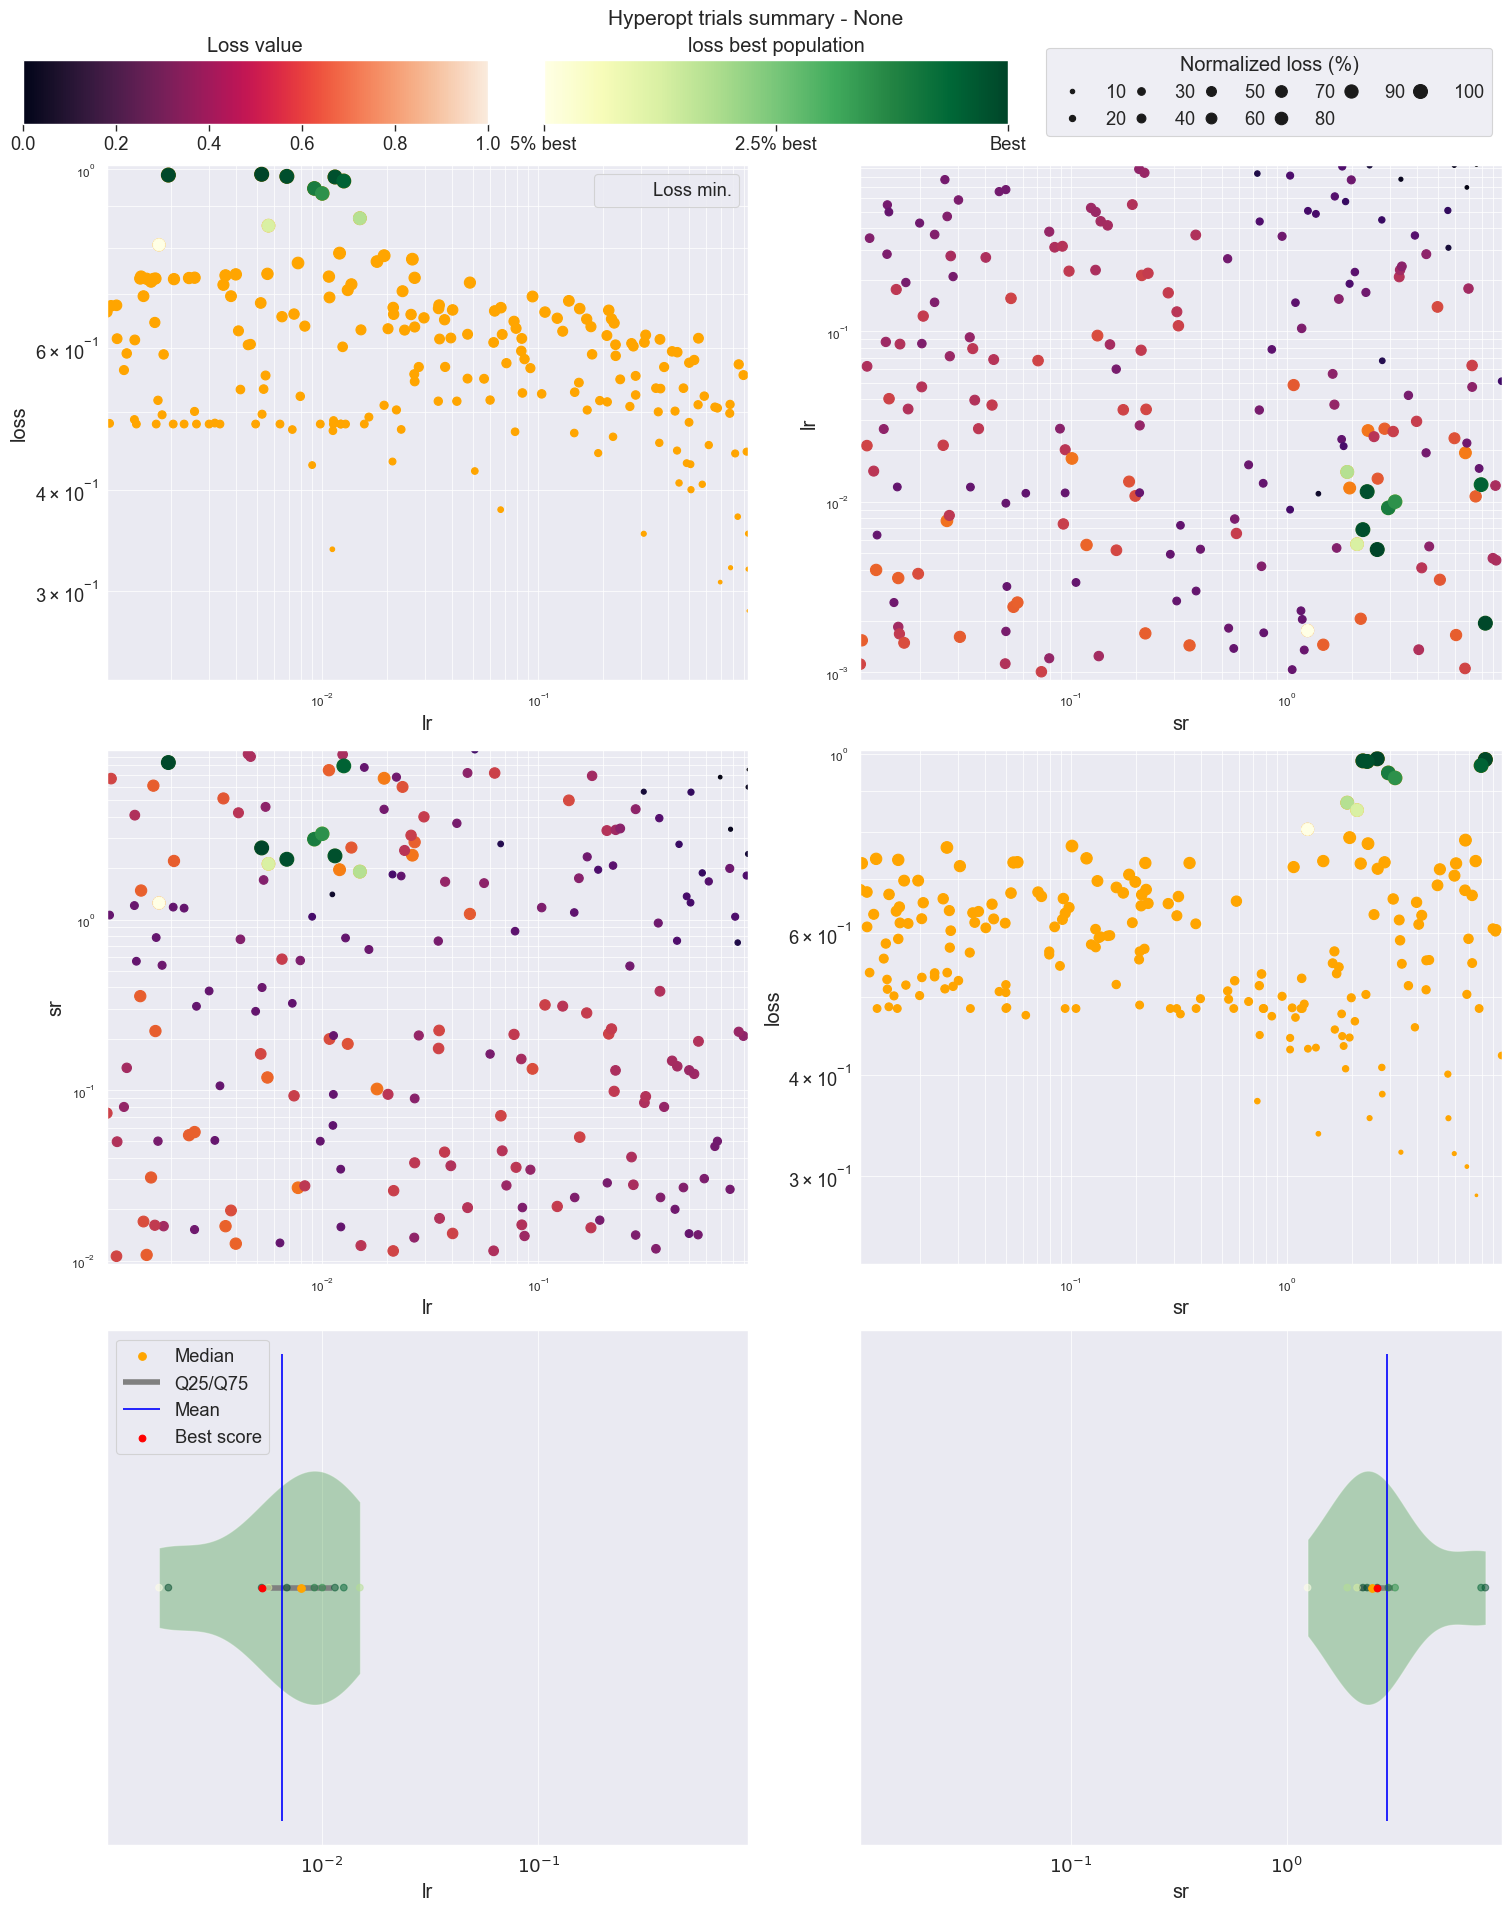

In [25]:
from reservoirpy.hyper import plot_hyperopt_report

fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "sr"), metric="loss")